### Importar Librerías Necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

### Implementacion SVM

In [2]:
def svm_sgd(X, y, C=1, lr=0.001, epochs=100):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    losses = []

    for epoch in range(epochs):
        # Calculamos la pérdida y el gradiente
        distances = 1 - y * (np.dot(X, w) + b)
        dw = np.zeros(n)
        db = 0
        loss = 0

        for i, d in enumerate(distances):
            if d > 0:
                dw += -C * y[i] * X[i]
                db += -C * y[i]
                loss += d
            else:
                dw += 0
                db += 0
        # Añadir la regularización
        dw = w + dw / m
        db = db / m
        loss = 0.5 * np.dot(w, w) + C * loss / m

        # Actualizar los pesos
        w -= lr * dw
        b -= lr * db

        losses.append(loss)

    return w, b, losses

## Cargar y Preparar las Imágenes de Entrenamiento

### Función para Cargar una Imagen y Extraer los Píxeles

In [3]:
def load_image_pixels(image_path):
    image = Image.open(image_path)
    pixels = np.array(image)
    return pixels


### Cargar las Imágenes y Extraer los Píxeles

In [4]:
# Cargar imágenes
cow_pixels = load_image_pixels('../images/train/vaca.jpg')
grass_pixels = load_image_pixels('../images/train/pasto.jpg')
sky_pixels = load_image_pixels('../images/train/cielo.jpg')

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cow_pixels)
plt.title('Vaca')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grass_pixels)
plt.title('Pasto')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sky_pixels)
plt.title('Cielo')
plt.axis('off')

plt.show()

### Preparar los Datos y Etiquetas

In [6]:
# Función para convertir los píxeles en una matriz de características y etiquetas
def prepare_data(cow_pixels, grass_pixels, sky_pixels):
    # Aplanar las matrices de píxeles y extraer las características RGB
    X_cow = cow_pixels.reshape(-1, 3)
    X_grass = grass_pixels.reshape(-1, 3)
    X_sky = sky_pixels.reshape(-1, 3)
    
    # Crear etiquetas
    y_cow = np.ones(X_cow.shape[0])       # Clase +1 para 'vaca'
    y_grass = -np.ones(X_grass.shape[0])  # Clase -1 para 'no vaca' (pasto)
    y_sky = -np.ones(X_sky.shape[0])      # Clase -1 para 'no vaca' (cielo)
    
    # Combinar los datos y etiquetas
    X = np.vstack((X_cow, X_grass, X_sky))
    y = np.hstack((y_cow, y_grass, y_sky))
    
    return X, y

### Entrenar

In [89]:
X_train, y_train = prepare_data(cow_pixels, grass_pixels, sky_pixels)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
lr_values = [0.001, 0.01, 0.1, 1]

results = []

for C in C_values:
    for lr in lr_values:
        w, b, _ = svm_sgd(X_train, y_train, C=C, lr=lr, epochs=100)
        results.append((C, lr, w, b))

In [ ]:
# Contar el número de muestras por clase
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print('Distribución de clases:', class_distribution)

### Cargar la Imagen Compuesta y Preparar los Píxeles para Clasificar

In [91]:
# Cargar la imagen compuesta
composite_image = Image.open('../images/cow.jpg')  # Reemplaza con el nombre de tu imagen
composite_pixels = np.array(composite_image)

# Obtener las dimensiones de la imagen
height, width, channels = composite_pixels.shape

# Aplanar los píxeles para clasificarlos
X_test = composite_pixels.reshape(-1, 3)


### Aplicar el Modelo para Clasificar Cada Píxel

In [92]:
# Función de predicción
def svm_predict_pixel(X, w, b):
    return np.sign(np.dot(X, w) + b)
  
# Predecir las clases de los píxeles
preds = []
for model in results:
    w = model[2]
    b = model[3]
    preds.append(svm_predict_pixel(X_test, w, b))


### Generar la Máscara de Segmentación

In [ ]:
for i, pred in enumerate(preds):
    y_pred = pred.reshape(height, width)
    plt.imshow(y_pred, cmap='gray')
    C, lr, _, _ = results[i]
    plt.title(f'C={C}, lr={lr}')
    plt.axis('off')
    plt.show()


# Extensión One-vs-All

### Preparar los Datos para Multiclase

In [7]:
def prepare_multiclass_data(cow_pixels, grass_pixels, sky_pixels):
    X_cow = cow_pixels.reshape(-1, 3)
    X_grass = grass_pixels.reshape(-1, 3)
    X_sky = sky_pixels.reshape(-1, 3)
    
    y_cow = np.zeros(X_cow.shape[0], dtype=int)       # Clase 0 para 'vaca'
    y_grass = np.ones(X_grass.shape[0], dtype=int)    # Clase 1 para 'pasto'
    y_sky = np.full(X_sky.shape[0], 2, dtype=int)     # Clase 2 para 'cielo'
    
    X = np.vstack((X_cow, X_grass, X_sky))
    y = np.hstack((y_cow, y_grass, y_sky))
    
    return X, y

In [8]:
X_train, y_train = prepare_multiclass_data(cow_pixels, grass_pixels, sky_pixels)

### Implementción del SVM Multiclase One-vs-All

Para cada clase, entrenaremos un SVM binario que distingue entre esa clase y el resto.

In [9]:
def train_multiclass_svm(X, y, C=0.1, epochs=100, lr=0.1):
    classes = np.unique(y)
    models = {}
    
    for cls in classes:
        # Crear etiquetas binarias para la clase actual
        y_binary = np.where(y == cls, 1, -1)
        # Entrenar el SVM binario
        w, b, _ = svm_sgd(X, y_binary, C=C, epochs=epochs, lr=lr)
        models[cls] = (w, b)
    return models

### Entrenar los modelos

In [16]:
C_values = [0.001]
lr_values = [0.001, 0.01, 0.1, 1]

models = {}
for C in C_values:
    for lr in lr_values:
        key = (C, lr)
        models[key] = train_multiclass_svm(X_train, y_train, epochs=100, C=C, lr=lr)

### Clasificar los Píxeles de la Imagen Compuesta

In [17]:
# Cargar y preparar la imagen compuesta
composite_image = Image.open('../images/cow.jpg')
composite_pixels = np.array(composite_image)
height, width, channels = composite_pixels.shape
X_test = composite_pixels.reshape(-1, 3)

Para cada modelo, obtenemos las puntuaciones y luego asignamos la clase con la puntuación más alta.

In [18]:
def predict_multiclass_svm(X, models):
    scores = np.zeros((X.shape[0], len(models)))
    for cls, (w, b) in models.items():
        scores[:, cls] = np.dot(X, w) + b
    # Asignar la clase con la puntuación más alta
    y_pred = np.argmax(scores, axis=1)
    return y_pred

In [19]:
y_preds = {}
for key, model in models.items():
    y_preds[key] = predict_multiclass_svm(X_test, model)

### Generar la Imagen de Segmentación

Asignamos colores distintivos a cada clase para visualizar la segmentación.

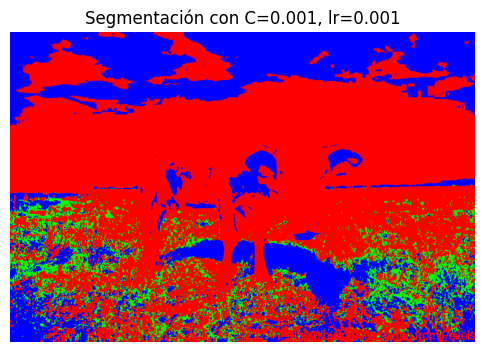

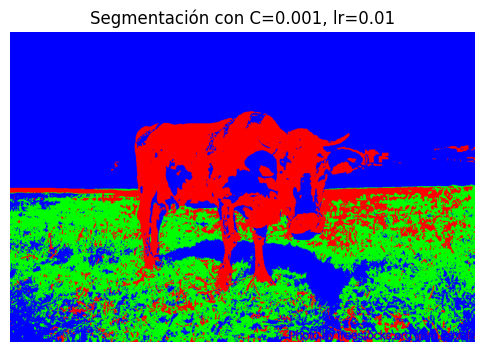

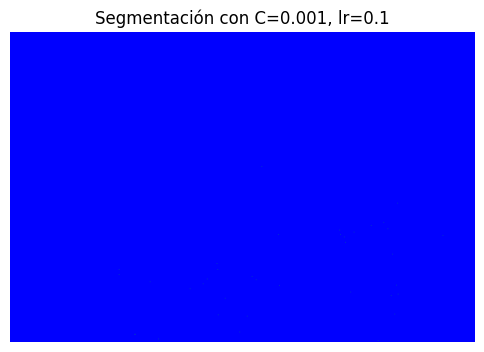

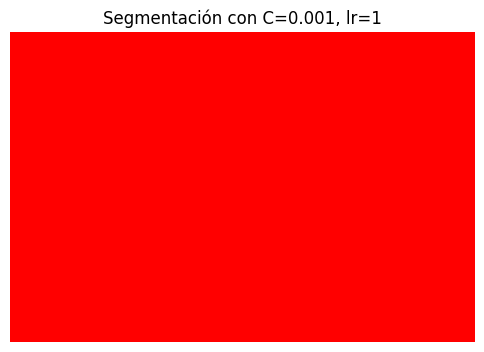

In [20]:
# Mapear cada clase a un color
color_map = {
    0: [255, 0, 0],   # Rojo para 'vaca'
    1: [0, 255, 0],   # Verde para 'pasto'
    2: [0, 0, 255]    # Azul para 'cielo'
}

for key, y_pred in y_preds.items():
    segmented_image = np.zeros((height * width, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        segmented_image[y_pred == cls] = color
    segmented_image = segmented_image.reshape((height, width, 3))
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_image)
    plt.title(f'C={key[0]}, lr={key[1]}')
    plt.axis('off')
    plt.show()